# 导入包

In [2]:
import sys
import os

python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import my_tools
import fid_score as official_fid

model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as all_model

# 使用inception_v3获取
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
import torch.nn.functional as F

from CIFAR10.models import BigGAN

from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import spatial

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F
import torchvision.transforms as transforms
from PIL import Image 

# 确定参数

In [4]:
dataset_type = "CIFAR10" # 数据集类型
latent_method = "supervised-cnn-ae" # 潜空间构造方法
device = torch.device("cuda:0")
iter_number = 1 # 总共取多少个数据点

whether_generate_random_pic = True # 是否从原始的208维空间中采样数据
whether_generate_2D_pic = True # 是否从构造的2D潜空间中采样数据


# 生成潜空间数据

In [3]:
if dataset_type == "CIFAR10" and whether_generate_random_pic:
    # 选择生成模型
    checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"
    G = BigGAN.Generator().to(device)
    G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
    G.eval()
    number = 290000 # 相当于从50开始

    for i in range(iter_number):
        number += 10000 
        save_pic_path = "./临时垃圾-随时可删/数据量实验/CIFAR10/pic/random_" + str(number)

        # 创建目录
        try:
            # 创建目录
            os.mkdir(save_pic_path)
        except FileExistsError:
            # print(save_pic_path + "目录已存在")
            pass
        except OSError as e:
            print(f"{save_pic_path} 创建目录时发生错误：{e}")

        for num in tqdm(range(number)):
            z = torch.tensor(np.random.RandomState(num).randn(1, 80)).to(torch.float32).to(device)    # latent code
            label = torch.tensor(random.randrange(10)).unsqueeze(0).to(device)
            shared_label = G.shared(label)
            z_and_shared_label = torch.cat((z, shared_label), dim = 1)
            if num == 0:
                z_and_shared_labels = z_and_shared_label
                labels = label
            else:
                z_and_shared_labels = torch.cat((z_and_shared_labels, z_and_shared_label))
                labels = torch.cat((labels, label))
            img = G(z = z_and_shared_label)                           # NCHW, float32, dynamic range [-1, +1]
            img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
            # print(z.shape) # [1, 80]
            # print(shared_label.shape) # [1, 128]
            # print(z_and_shared_label.shape) # [1, 208]
            utils.save_image(img.detach().cpu(), save_pic_path + '/pic_' + str(num) + '.png')

        torch.save(z_and_shared_labels, "./临时垃圾-随时可删/数据量实验/CIFAR10/latent_z/latent_z_random_" + str(number) + ".pt")
        torch.save(labels, "./临时垃圾-随时可删/数据量实验/CIFAR10/labels/labels_random_" + str(number) + ".pt")
        print(f"{number}: z_and_shared_labels.shape = {z_and_shared_labels.shape}, labels.shape = {labels.shape}")

100%|██████████| 300000/300000 [46:02<00:00, 108.61it/s]


300000: z_and_shared_labels.shape = torch.Size([300000, 208]), labels.shape = torch.Size([300000])


# 不同的潜空间构造方法

## 1、vae直接对潜向量进行降维

In [4]:
if latent_method == "VAE" and whether_generate_2D_pic:
    # 定义VAE模型
    class VAE(nn.Module):
        def __init__(self, latent_dim):
            super(VAE, self).__init__()

            self.latent_dim = latent_dim

            # 编码器
            self.encoder = nn.Sequential(
                nn.Linear(208, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
            )
            self.fc_mu = nn.Linear(256, latent_dim)
            self.fc_logvar = nn.Linear(256, latent_dim)

            # 解码器
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 512),
                nn.ReLU(),
                nn.Linear(512, 208),
                nn.Sigmoid()
            )

        def encode(self, x):
            x = self.encoder(x)
            mu = self.fc_mu(x)
            logvar = self.fc_logvar(x)
            return mu, logvar

        def reparameterize(self, mu, logvar):
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std
            return z
        
        def get_2D(self, x):
            mu, logvar = self.encode(x.view(-1, 208))
            z = self.reparameterize(mu, logvar)
            return z

        def decode(self, z):
            x = self.decoder(z)
            return x

        def forward(self, x):
            mu, logvar = self.encode(x.view(-1, 208))
            z = self.reparameterize(mu, logvar)
            x_recon = self.decode(z)
            return x_recon, mu, logvar
    # 自定义datasets
    class My_vae_data_sets(Dataset):
        def __init__(self, path, device, transform=None):
            super(My_vae_data_sets, self).__init__()
            self.latent_z = torch.load(path, map_location=device)

        def __getitem__(self, index):
            z = self.latent_z[index].detach()
            return z

        def __len__(self):
            return len(self.latent_z)
    # 自定义zsdatasets
    # 用来处理zs的类，方便使用batchsize
    class My_zs_data_sets(Dataset):
        
        def __init__(self, zs):
            super(My_zs_data_sets, self).__init__()
            self.zs = zs

        def __getitem__(self, index):
            z = self.zs[index]
            return z

        def __len__(self):
            return len(self.zs)
    
    # 插值函数，不对类向量进行插值，类取最近的那一个点
    def get_zs_prevent_stick_not_class(coordinates, kdTree_2D, latent_z, k=20):
        '''
        nearest_distance: n*k维
        nearest_index: n*k维
        dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
        '''
        print("进入了防止粘在一块，并且不对控制类别的向量进行插值~~~~~~~~~~~~~~~~~~")
        # 直接一次查询所有坐标的k个近邻
        nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
        origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
        for i, pos in enumerate(coordinates): #对每一个坐标进行插值
            # pos坐标对应的近邻下标
            pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
            pos_nearst_distance = nearest_distance[i]

            # 最近邻的坐标点，以及最近的距离
            most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
            most_nearst_dis = pos_nearst_distance[0]

            # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
            s1 = most_nearst_dis
            best_index = 1 # 默认第二个最近邻最好
            min_dif = 100
            for j in range(1, k):
                cur_pos = origin_coordinates[pos_nearst_index[j]]
                s2 = pos_nearst_distance[j]
                s3 = np.linalg.norm(most_nearst_pos-cur_pos)
                if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                    min_dif = (s1 + s2) - s3
                    best_index = j
            
            temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
            temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
            sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
            z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

            z_new[-128:] = temp_z_0[-128:] # 不修改类标签

            z_new = z_new.unsqueeze(0)
            if i == 0:
                zs = z_new
            else:
                zs = torch.cat((zs, z_new), dim=0)

        return zs
    
    # 最开始的版本，就取近邻的向量进行插值，但是不对类的向量进行插值
    def get_zs_new_not_class(coordinates, kdTree_2D, latent_z, k=20):
        '''
        coordinates: n个要插值的坐标
        kdTree_2D: 降维后的2D坐标
        latent_z: 生成模型的输入潜向量，和kdTree_2D是一一对应关系
        k: 近邻的数量
        '''
        print("最开始的版本，优化了一下代码~~~~~~~~~~~ k:",k)
        # 直接一次查询所有坐标的k个近邻
        nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k) #这里的k为固定值
        origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
        for iter in range(len(coordinates)):
            iter_distance = nearest_distance[iter]
            iter_index = nearest_index[iter]
            
            sum_distanceForIter = np.sum(iter_distance) #这k个近邻的距离总和
            for i, index in enumerate(iter_index):
                temp_z = torch.tensor(latent_z[index])
                temp_distance = iter_distance[i]
                w = (sum_distanceForIter-temp_distance)/((k-1)*sum_distanceForIter) #对z进行权重
                if i == 0:
                    z = temp_z*w
                else:
                    z += temp_z*w

            z[-128:] = latent_z[iter_index[0]][-128:]   #类向量为最近的那一个点的向量

            z = z.unsqueeze(0) # shape:[1*latent_dim]
            if iter == 0:
                zs = z
            else:
                zs = torch.cat((zs, z), dim=0)
            # print(zs.shape)
        return zs

    vae_path = os.path.join("./临时垃圾-随时可删/20230814vae训练", "vae_state_dict_epoch = 100 kl = 0.015 cl_w = 1.2 loss = 0.028671982766389846 loss_fn=official 2023-08-17 19:07:10.pt")
    # 初始化VAE模型
    vae = VAE(2)
    vae.load_state_dict(torch.load(vae_path, map_location=device))
    vae = vae.to(device)
    vae.eval()
    number = 40000
    # 循环生成降维后的kd树
    for i in range(iter_number):
        number += 10000
        # 加载数据集
        datasets = My_vae_data_sets("./临时垃圾-随时可删/数据量实验/CIFAR10/latent_z/latent_z_random_" + str(number) + ".pt", device = device)
        dataLoader = DataLoader(datasets, batch_size=32, shuffle=False)
        # 使用vae对潜向量进行降维
        with torch.no_grad():
            for i, data in enumerate(dataLoader):
                data = data.to(device)
                mu, logvar = vae.encode(data.view(-1, 208))
                zs = vae.reparameterize(mu, logvar)
                if i == 0:
                    z_2ds = zs
                else:
                    z_2d = zs
                    z_2ds = torch.cat((z_2ds, z_2d))
        print("z_2ds.shape: ", z_2ds.shape)
        # 将张量转换为 NumPy 数组
        zs_np = z_2ds.to(torch.device("cpu")).detach().numpy()
        # 读取类别标签（每一个向量对应一个类别）
        labels = torch.load("./临时垃圾-随时可删/数据量实验/CIFAR10/labels/labels_random_" + str(number) + ".pt")
        # 获取类别数量和颜色映射
        color_map = plt.get_cmap("tab10")
        cifar10_labels = [
            "airplane", "automobile", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"
        ]
        # 画图检查
        labels = labels.to(torch.device("cpu")).detach().numpy()
        plt.scatter(zs_np[:, 0], zs_np[:, 1], s=0.05, c=labels, cmap=color_map)
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        title = "The scatter plot of number: " + str(number)
        plt.title(title)
        plt.colorbar(label="Class")
        # 添加类别标签
        for i in range(10):
            label = cifar10_labels[i]
            x = zs_np[labels == i, 0].mean()
            y = zs_np[labels == i, 1].mean()
            plt.text(x, y, label, fontsize=8, ha='center', va='center', weight='bold')
        # 保存图像
        plt.savefig("./临时垃圾-随时可删/数据量实验/CIFAR10/latent_method/vae_208z/kd_tree/tree_2D_" + str(number) + ".png") 
        plt.clf()

        # 建立搜索树
        tree_2D = spatial.KDTree(data=zs_np)
        torch.save(tree_2D, "./临时垃圾-随时可删/数据量实验/CIFAR10/latent_method/vae_208z/kd_tree/tree_2D_" + str(number) + ".pt")

        
        # 计算坐标点的协方差矩阵
        coords = tree_2D.data
        cov = np.cov(coords.T)

        # 生成符合多元正态分布的新坐标点
        new_coords = np.random.multivariate_normal(np.mean(coords, axis=0), cov, size=50000)

        # 插值生成新的向量
        latent_z_path = "./临时垃圾-随时可删/数据量实验/CIFAR10/latent_z/latent_z_random_" + str(number) + ".pt"
        latent_z = torch.load(latent_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错 
        zs = get_zs_prevent_stick_not_class(new_coords, tree_2D, latent_z)
        zs_datasets = My_zs_data_sets(zs)
        zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)

        model_files_dir = "./model_files/" # 模型位置
        sys.path.append(model_files_dir)
        import model_files as model_all
        checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"
        G = model_all.get_generative_model("CIFAR10").to(device)
        G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
        G.eval()

        # 创建保存的目录
        save_2dpic_path = "./临时垃圾-随时可删/数据量实验/CIFAR10/latent_method/vae_208z/2D_pic/2D_pic_" + str(number)
        # 创建目录
        try:
            # 创建目录
            os.mkdir(save_2dpic_path)
        except FileExistsError:
            # print(save_pic_path + "目录已存在")
            pass
        except OSError as e:
            print(f"{save_2dpic_path} 创建目录时发生错误：{e}")

        print("开始生成图片。。。")
        first = 0 # 判断是否第一次进入循环
        count = 0
        with torch.no_grad(): # 取消梯度计算，加快运行速度
            for batch_z in zs_loader: 
                z = torch.tensor(batch_z).to(torch.float32).to(device)    # latent code
                imgs = G(z)   
                for i, img in enumerate(imgs):
                    img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
                    utils.save_image(img.detach().cpu(), f"{save_2dpic_path}/pic_{count}.png")
                    count += 1

## 2、使用supervised-cnn-ae结合tsne

ids:  tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127])
降维之前zs.shape： torch.Size([300000, 192])
降维之后zs.shape： (300000, 2)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

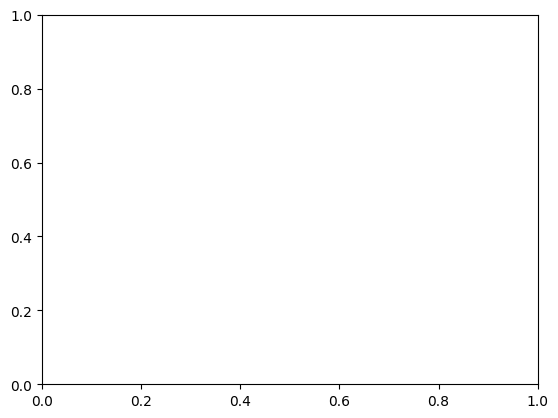

In [8]:
if latent_method == "supervised-cnn-ae" and whether_generate_2D_pic:
    class Autoencoder(nn.Module):
        def __init__(self):
            super(Autoencoder, self).__init__()
            self.encoder = nn.Sequential( 
                nn.Conv2d(3, 12, kernel_size=4, stride=2, padding=1), #3x32x32 to 12x16x16
                nn.BatchNorm2d(12),
                nn.ReLU(),
                nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1), #12x16x16 to 24x8x8
                nn.BatchNorm2d(24),
                nn.ReLU(),
                nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1), #24x8x8 to 48x4x4
                nn.BatchNorm2d(48),
                nn.ReLU(),
                nn.Conv2d(48, 96, kernel_size=4, stride=2, padding=1), #48x4x4 to 96x2x2
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.Conv2d(96, 192, kernel_size=4, stride=2, padding=1), #96x2x2 to 192x1x1
                nn.BatchNorm2d(192),
                nn.ReLU()
            )

            # kjl多加一个类别层
            self.classifier = nn.Sequential(
                nn.Linear(192, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 10),
            )
            
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(192, 96, kernel_size=4, stride=2, padding=1, output_padding=0), #192x1x1 to 96x2x2
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.ConvTranspose2d(96, 48, kernel_size=4, stride=2, padding=1, output_padding=0), #96x2x2 to 48x4x4
                nn.BatchNorm2d(48),
                nn.ReLU(),
                nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1, output_padding=0), #48x4x4 to 24x8x8
                nn.BatchNorm2d(24),
                nn.ReLU(),
                nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1, output_padding=0), #24x8x8 to 12x16x16
                nn.BatchNorm2d(12),
                nn.ReLU(),
                nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1, output_padding=0), #12x16x16 to 3x32x32
                nn.BatchNorm2d(3),
                nn.Tanh()
            )
        # defined the forward function to take input
        # call the encoder to encod the input
        # call the decoder function to decode the encoded inpu
        def forward(self, x):
            encoded = self.encoder(x)

            temp = encoded # 层数最高的卷积
            emb = temp.view(encoded.size(0), -1) #flatten
            pre = self.classifier(emb)

            decoded = self.decoder(encoded)
            return encoded, decoded, pre

        #with an pooling on output of trained encoder we have an embeding vector for each image 
        #this vector can used for MLP or other method for prediction
        def embedding(self,x):
            encoded = self.encoder(x)
            # encoded = nn.AvgPool2d(2,2)(encoded) #48*4*4-->48x2x2 embedded features # 层数最高的卷积不能有这个
            encoded = encoded.view(encoded.size(0), -1)   #flatten 48x2x2->192
            return encoded

    # 自定义datasets
    class My_vae_data_sets(Dataset):
        def __init__(self, path, device, transform=None):
            super(My_vae_data_sets, self).__init__()
            self.latent_z = torch.load(path, map_location=device)

        def __getitem__(self, index):
            z = self.latent_z[index].detach()
            return z

        def __len__(self):
            return len(self.latent_z)
    # 自定义zsdatasets
    # 用来处理zs的类，方便使用batchsize
    class My_zs_data_sets(Dataset):
        
        def __init__(self, zs):
            super(My_zs_data_sets, self).__init__()
            self.zs = zs

        def __getitem__(self, index):
            z = self.zs[index]
            return z

        def __len__(self):
            return len(self.zs)
    
    # 自定义datasets(读取图片数据集的)
    class My_pics_data_sets(Dataset):
        def __init__(self, path, transform=None):
            super(My_pics_data_sets, self).__init__()
            self.root_dir = path
            self.img_names = os.listdir(self.root_dir)
            self.img_names.sort(key = lambda x : int(x[4:-4]))
            self.transform = transform

        def __getitem__(self, index):
            img_name = self.img_names[index]
            img = Image.open(os.path.join(self.root_dir, img_name))
            id_name = torch.tensor(int(img_name[4:-4])) #pic_xx.jpg
            if self.transform is not None:
                img = self.transform(img)
            return img, id_name

        def __len__(self):
            return len(self.img_names)

    class FloatTransformer(object):
        def __call__(self, tensor):
            return tensor.type(torch.FloatTensor)
    ae_transfrom = transforms.Compose([transforms.ToTensor(),
                                FloatTransformer(), #[0,255]->[0,1]
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 


    # 插值函数，不对类向量进行插值，类取最近的那一个点
    def get_zs_prevent_stick_not_class(coordinates, kdTree_2D, latent_z, k=20):
        '''
        nearest_distance: n*k维
        nearest_index: n*k维
        dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
        '''
        print("进入了防止粘在一块，并且不对控制类别的向量进行插值~~~~~~~~~~~~~~~~~~")
        # 直接一次查询所有坐标的k个近邻
        nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
        origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
        for i, pos in enumerate(coordinates): #对每一个坐标进行插值
            # pos坐标对应的近邻下标
            pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
            pos_nearst_distance = nearest_distance[i]

            # 最近邻的坐标点，以及最近的距离
            most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
            most_nearst_dis = pos_nearst_distance[0]

            # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
            s1 = most_nearst_dis
            best_index = 1 # 默认第二个最近邻最好
            min_dif = 100
            for j in range(1, k):
                cur_pos = origin_coordinates[pos_nearst_index[j]]
                s2 = pos_nearst_distance[j]
                s3 = np.linalg.norm(most_nearst_pos-cur_pos)
                if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                    min_dif = (s1 + s2) - s3
                    best_index = j
            
            temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
            temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
            sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
            z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

            z_new[-128:] = temp_z_0[-128:] # 不修改类标签

            z_new = z_new.unsqueeze(0)
            if i == 0:
                zs = z_new
            else:
                zs = torch.cat((zs, z_new), dim=0)

        return zs
    
    # 最开始的版本，就取近邻的向量进行插值，但是不对类的向量进行插值
    def get_zs_new_not_class(coordinates, kdTree_2D, latent_z, k=20):
        '''
        coordinates: n个要插值的坐标
        kdTree_2D: 降维后的2D坐标
        latent_z: 生成模型的输入潜向量，和kdTree_2D是一一对应关系
        k: 近邻的数量
        '''
        print("最开始的版本，优化了一下代码~~~~~~~~~~~ k:",k)
        # 直接一次查询所有坐标的k个近邻
        nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k) #这里的k为固定值
        origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
        for iter in range(len(coordinates)):
            iter_distance = nearest_distance[iter]
            iter_index = nearest_index[iter]
            
            sum_distanceForIter = np.sum(iter_distance) #这k个近邻的距离总和
            for i, index in enumerate(iter_index):
                temp_z = torch.tensor(latent_z[index])
                temp_distance = iter_distance[i]
                w = (sum_distanceForIter-temp_distance)/((k-1)*sum_distanceForIter) #对z进行权重
                if i == 0:
                    z = temp_z*w
                else:
                    z += temp_z*w

            z[-128:] = latent_z[iter_index[0]][-128:]   #类向量为最近的那一个点的向量

            z = z.unsqueeze(0) # shape:[1*latent_dim]
            if iter == 0:
                zs = z
            else:
                zs = torch.cat((zs, z), dim=0)
            # print(zs.shape)
        return zs

    # 插值函数，反距离权重插值
    def get_zs_idw_not_class(coordinates, kdTree_2D, latent_z, k=20, p=50):
        '''
        nearest_distance: n*k维
        nearest_index: n*k维
        dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
        '''
        print("进入了反距离权重插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~")
        # 直接一次查询所有坐标的k个近邻
        nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
        origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
        for i, pos in enumerate(coordinates): #对每一个坐标进行插值
            # pos坐标对应的近邻下标
            pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
            pos_nearst_distance = nearest_distance[i]
            weights = torch.tensor(1.0 / (pos_nearst_distance + 1e-8)) # 避免除以零，加上一个小的常数

            # 计算加权平均
            weighted_values = latent_z[pos_nearst_index].clone().detach() * weights[:, None] ** p
            z_new = torch.sum(weighted_values, dim=0) / torch.sum(weights**p)
            

            z_new[-128:] = latent_z[pos_nearst_index[0]][-128:].clone().detach()   #类向量为最近的那一个点的向量
            z_new = z_new.unsqueeze(0)
            if i == 0:
                zs = z_new
            else:
                zs = torch.cat((zs, z_new), dim=0)

        return zs

    AE = Autoencoder()
    AE = AE.to(device)
    AE.load_state_dict(torch.load("./model_files/CIFAR10/checkpoints/supervised_cnn_ae/5_layer_autoencoder_adam_lr=0.001_cl_weight=1_recon_weight=1_torch.Size([128, 192]).pkl", map_location=device))
    AE.eval()
    number = 290000
    # 循环生成降维后的kd树
    for i in range(iter_number):
        number += 10000
        # 加载数据集

        # 加载数据集
        pics_datasets = My_pics_data_sets("./临时垃圾-随时可删/数据量实验/CIFAR10/pic/random_" + str(number), ae_transfrom)
        pics_dataloader = torch.utils.data.DataLoader(
                        dataset=pics_datasets,
                        batch_size=128,
                        shuffle=False)
        # 使用AE进行降维
        model = AE
        model.eval()
        num = 0
        with torch.no_grad():
            for pics, ids in pics_dataloader:
                pics = pics.to(device)
                z = model.embedding(pics)
                if num == 0:
                    zs = z
                    # all_pics = pics
                    num = 1
                    print("ids: ", ids)
                else:
                    zs = torch.cat((zs, z), dim = 0)
                    # all_pics = torch.cat((all_pics, pics), dim = 0)
        print("降维之前zs.shape：", zs.shape)
        # 可能比较耗时
        from openTSNE import TSNE
        zs = zs.detach().cpu()
        zs = TSNE(n_jobs=4).fit(zs)  # 输出N, 2
        print("降维之后zs.shape：", zs.shape)

        


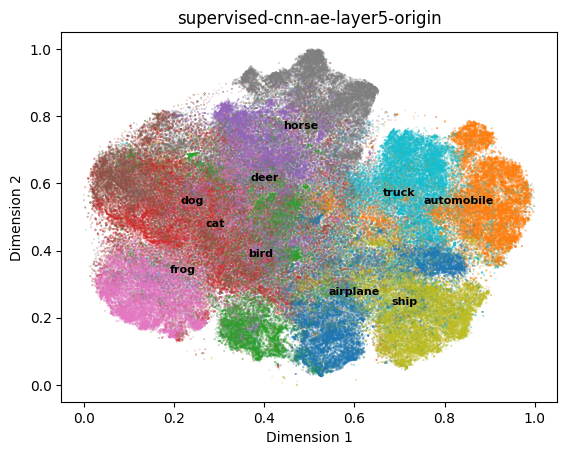

采样后的长度： 50000


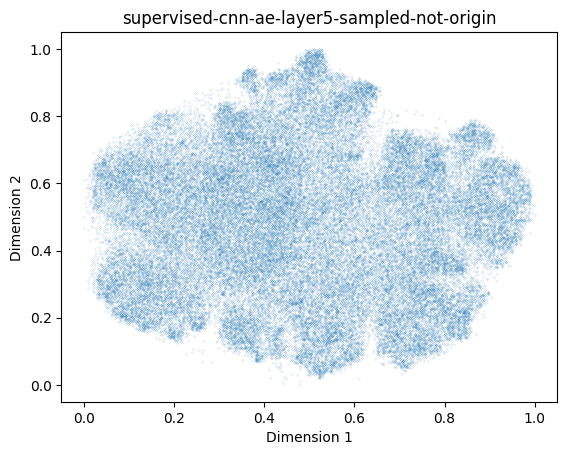

进入了反距离权重插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~
开始生成图片。。。


/home/user_home/kuangjielong/.conda/envs/python3_7/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [10]:
        # 读取类别标签（每一个向量对应一个类别）
        labels = torch.load("./临时垃圾-随时可删/数据量实验/CIFAR10/labels/labels_random_" + str(number) + ".pt")
        labels = labels.detach().cpu()

        # 绘制散点图
        import torch
        import numpy as np
        import matplotlib.pyplot as plt

        # labels = torch.load("./临时垃圾-随时可删/labels.pt")
        cifar10_labels = [
            "airplane", "automobile", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"
        ]

        title = f"supervised-cnn-ae-layer5-origin"

        # 进行归一化到[0,1]*[0,1]
        zs_np = zs
        # np.max(array1, axis=0)的意思就是：按第一个维度（即，行）对array1进行拆分，得到array1[0, :]、array1[1, :]、array1[2, :]，然后对array1[0, :]、array1[1, :]、array1[2, :]的对应元素进行逐位比较，并取其最大者，构成新的ndarray。
        min_val = np.min(zs_np, axis=0)
        max_val = np.max(zs_np, axis=0)
        zs_np = (zs_np - min_val) / (max_val - min_val) 

        # 获取类别数量和颜色映射
        color_map = plt.get_cmap("tab10")

        # 绘制散点图
        plt.scatter(zs_np[:, 0], zs_np[:, 1], s=0.01, c=labels, cmap=color_map)
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.title(title)
        # plt.colorbar(label="Class")

        # 添加类别标签
        for i in range(10):
            label = cifar10_labels[i]
            x = zs_np[labels == i, 0].mean()
            y = zs_np[labels == i, 1].mean()
            plt.text(x, y, label, fontsize=8, ha='center', va='center', weight='bold')
        plt.show()


        # 建立搜索树
        from scipy import spatial
        tree = spatial.KDTree(data=zs_np)

        # 采样
        # 打网格的密度采样，简化版本
        class density_based_latent_space_sampling_simply():
            def __init__(self, sampling_number=50000, grid_size=100):
                    super(density_based_latent_space_sampling_simply, self).__init__()
                    '''
                        sampling_number：采样的数量
                        grid_size：划分网格（grid_size*grid_size）
                    '''
                    self.sampling_number = sampling_number
                    self.grid_size = grid_size
                    return

            # 采样
            def sample(self, data):
                '''
                    注意data是归一化后的2维坐标数据：[0, 1] × [0, 1]
                '''

                # 获取数据样本数量
                n = data.shape[0]
                
                # 构建网格，返回每个网格中的样本数量，以及样本下标
                grid_count, grid_indexes = self._construct_grids(data, self.grid_size)

                # 计算每个网格的采样数量
                sample_count = np.ceil(grid_count * self.sampling_number / n).astype(int)

                all_coordinates = []
                for i in range(self.grid_size):
                    for j in range(self.grid_size):
                        if grid_count[i][j] > 0:
                            # 从当前网格中根据密度级别随机生成数据
                            x_min, x_max = i*1/self.grid_size, (i+1)/self.grid_size
                            y_min, y_max = j*1/self.grid_size, (j+1)/self.grid_size
                            # 生成随机二维坐标数组
                            coordinates = np.random.uniform(low=[x_min, y_min], high=[x_max, y_max], size=(sample_count[i][j], 2))
                            all_coordinates.append(coordinates)
                
                all_coordinates = np.concatenate(all_coordinates, axis=0)
                return all_coordinates

            # 构建网格
            def _construct_grids(self, data, grid_size):
                '''
                    返回值：
                    grid_count：统计每个网格中的样本数量
                    grid_indexes：记录每个网格中的样本的下标
                '''
                # 代码将输入数据乘以grid_size并转换为整数类型，得到离散化的数据discrete_full_data。这样做的目的是将数据映射到网格的坐标空间上。
                discrete_full_data = (data * grid_size).astype(int)
                # 通过np.where函数找到位于网格边界的数据点，并将其坐标减去1。这是为了保证所有数据点都在网格范围内，避免越界。
                discrete_full_data[np.where(discrete_full_data == grid_size)] -= 1
                # 代码创建了两个空数组：grid_count和grid_indexes。grid_count是一个大小为(grid_size, grid_size)的二维数组，用于统计每个网格中的数据点数量。grid_indexes是一个嵌套的二维列表，用于存储每个网格中数据点的索引。
                grid_count = np.zeros((grid_size, grid_size)).astype(int)
                grid_indexes = [[[] for _ in range(grid_size)] for __ in range(grid_size)]
                
                for k, single_data in enumerate(discrete_full_data):
                    grid_count[single_data[0], single_data[1]] += 1
                    grid_indexes[single_data[0]][single_data[1]].append(k)
                return grid_count, grid_indexes
        
        # 画图展示采样结果
        origin_sample = density_based_latent_space_sampling_simply(sampling_number=50000)
        sampled_coordinates = origin_sample.sample(zs_np)
        sampled_index = np.random.choice(len(sampled_coordinates), 50000, replace=False)
        sampled_coordinates = sampled_coordinates[sampled_index]
        print("采样后的长度：", len(sampled_coordinates))

        sampled_zs_np = sampled_coordinates

        title = f"supervised-cnn-ae-layer5-sampled-not-origin"

        # 进行归一化到[0,1]*[0,1]
        min_val = np.min(sampled_zs_np, axis=0)
        max_val = np.max(sampled_zs_np, axis=0)
        sampled_zs_np = (sampled_zs_np - min_val) / (max_val - min_val) 

        # 绘制散点图
        plt.scatter(sampled_zs_np[:, 0], sampled_zs_np[:, 1], s=0.01)
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.title(title)
        plt.show()

        # 插值生成新的向量
        latent_z_path = "./临时垃圾-随时可删/数据量实验/CIFAR10/latent_z/latent_z_random_" + str(number) + ".pt"
        latent_z = torch.load(latent_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错 
        zs = get_zs_idw_not_class(sampled_coordinates, tree, latent_z)
        zs_datasets = My_zs_data_sets(zs)
        zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)

        model_files_dir = "./model_files/" # 模型位置
        sys.path.append(model_files_dir)
        import model_files as model_all
        checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"
        G = model_all.get_generative_model("CIFAR10").to(device)
        G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
        G.eval()

        # 创建保存的目录
        save_2dpic_path = "./临时垃圾-随时可删/数据量实验/CIFAR10/latent_method/vae_208z/2D_pic/2D_pic_" + str(number)
        # 创建目录
        try:
            # 创建目录
            os.mkdir(save_2dpic_path)
        except FileExistsError:
            # print(save_pic_path + "目录已存在")
            pass
        except OSError as e:
            print(f"{save_2dpic_path} 创建目录时发生错误：{e}")

        print("开始生成图片。。。")
        first = 0 # 判断是否第一次进入循环
        count = 0
        with torch.no_grad(): # 取消梯度计算，加快运行速度
            for batch_z in zs_loader: 
                z = torch.tensor(batch_z).to(torch.float32).to(device)    # latent code
                imgs = G(z)   
                for i, img in enumerate(imgs):
                    img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
                    utils.save_image(img.detach().cpu(), f"{save_2dpic_path}/pic_{count}.png")
                    count += 1

# 计算IS值和fid值

In [5]:
# 自定义图片datasets
class My_pic_data_sets(Dataset):
    
    def __init__(self, path, transform=None):
        super(My_pic_data_sets, self).__init__()
        self.root_dir = path
        self.img_names = os.listdir(self.root_dir)
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img = Image.open(os.path.join(self.root_dir, img_name))
        id_name = torch.tensor(int(img_name[4:-4])) #pic_xx.jpg
        if self.transform is not None:
            img = self.transform(img)
        return img, id_name

    def __len__(self):
        return len(self.img_names)

if dataset_type == "CIFAR10":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

# 加载预训练的Inception模型
inception_model = inception_v3(pretrained=True, transform_input=False).eval()
inception_model.to(device)

number = 290000
for i in range(iter_number):
    number += 10000

    # 确定图像路径
    if dataset_type == "CIFAR10":
        is_pic_path = "./临时垃圾-随时可删/数据量实验/CIFAR10/latent_method/vae_208z/2D_pic/2D_pic_" + str(number)

    # 生成的图像数据集（假设你有一个名为generated_data的数据集）
    generated_dataset = My_pic_data_sets(path=is_pic_path,transform=transform)
    generated_dataloader = DataLoader(generated_dataset, batch_size=32, shuffle=True)

    # 计算预测分数
    predictions = []
    for images, ids in generated_dataloader:
        images = images.to(device)
        with torch.no_grad():
            images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            preds = inception_model(images)
        predictions.append(torch.softmax(preds, dim=1))

    predictions = torch.cat(predictions, dim=0)
    print("predictions.shape: ", predictions.shape)
    fake_probs = predictions
    # fake_probs.mean(dim=0, keepdim=True).shape
    # 计算Inception Score
    kl_divergence = (fake_probs * (fake_probs / fake_probs.mean(dim=0, keepdim=True)).log()).sum(dim=1)
    print(kl_divergence.shape)
    inception_score = torch.exp(kl_divergence.mean()).item()

    # fid计算模型
    dims = 2048
    batch_size = 1
    num_avail_cpus = len(os.sched_getaffinity(0))
    num_workers = min(num_avail_cpus, 8)
    block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    fid_model = official_fid.InceptionV3([block_idx], normalize_input=False).to(device)
    # fid_model = official_fid.InceptionV3([block_idx]).to(device)
    print('fid_model load success!')

    if dataset_type == "CIFAR10":
        pic_path_fid1 = './static/data/CIFAR10/pic/origin_50k_png'
        pic_path_fid2 = is_pic_path
        # pic_path_fid2 = "./临时垃圾-随时可删/数据量实验/CIFAR10/pic/random_300000/"

    batch_size = 100
    m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                        dims, device, num_workers)
    m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                        dims, device, num_workers)
    fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 

    # 打印并保存结果
    result = f"{number} inception Score: {inception_score}; FID Score: {fid_value}"
    print(result)
    file_path = "./临时垃圾-随时可删/数据量实验/CIFAR10/latent_method/vae_208z/result/result_" + str(number) + ".txt"
    with open(file_path, 'a') as file:
        # Write the text data to the file
        file.write(result)

predictions.shape:  torch.Size([50000, 1000])
torch.Size([50000])
fid_model load success!


100%|██████████| 3000/3000 [05:06<00:00,  9.77it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
300000 inception Score: 8.679023742675781; FID Score: 3.2894398161342906
